In [66]:
import pandas as pd
import numpy as np
from joblib import dump
import nltk
import contractions
import inflect
import re, string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.pipeline import Pipeline

In [67]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("TextPreprocessor initialized")
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        print("Fitting TextPreprocessor...")
        return self
        
    def transform(self, X, y=None):
        print("Transforming text...")
        return self.preprocess(X)
        
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame:
        print("Preprocessing text...")
        # convert series to dataframe
        df = pd.DataFrame(df)
        print("Step 1/10", end="\r")
        df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
        print("Step 2/10", end="\r")
        df['no_constractions'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
        print("Step 3/10", end="\r")
        df['text'] = [' '.join(map(str, l)) for l in df['no_constractions']]
        print("Step 4/10", end="\r")
        df['tokenized'] = df['text'].apply(nltk.word_tokenize)
        print("Step 5/10", end="\r")
        df['tokenized'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])
        print("Step 6/10", end="\r")
        punc = string.punctuation
        df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in punc])
        print("Step 7/10", end="\r")
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
        print("Step 8/10", end="\r")
        df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
        print("Step 9/10", end="\r")
        df['tokenized_str'] = [' '.join(map(str,l)) for l in df['tokenized']]
        print("Step 10/10")
        df_clean = df['tokenized_str']
        # rename tokenized_str to text
        print("Finished preprocessing text...")
        return df_clean
        

In [68]:
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(tokenizer=nltk.TweetTokenizer().tokenize, 
                                   stop_words=(set(stopwords.words('english')).union(['4661', 'meeeeeeeeeeee', 'ja', '01457654035', 'reaally', '3624', '3904512441', 'mesooo', 'ان فرع', '']))
                                   )
    ),
    ('classifier', MLPClassifier(verbose=True, early_stopping=True))
])

TextPreprocessor initialized


In [69]:
ruta = "../data/SuicidiosProyecto.csv"
data = pd.read_csv(ruta, encoding="utf-8", index_col=0)

In [70]:
data.head()

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,I kinda got behind schedule with learning for ...,non-suicide
256637,I'm just not sure anymoreFirst and foremost: I...,suicide
303772,please give me a reason to liveThats too much ...,suicide
293747,27f struggling to find meaning moving forwardI...,suicide


In [71]:
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.3, random_state=28)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(136990,) (58710,) (136990,) (58710,)


In [72]:
pipeline.fit(x_train, y_train)

Fitting TextPreprocessor...
Transforming text...
Preprocessing text...
dataframe columns:  Index(['text'], dtype='object')


In [ ]:
pred_train = pipeline.predict(x_train)
pred_test = pipeline.predict(x_test)

Transforming text...
Preprocessing text...
dataframe columns:  Index(['text'], dtype='object')
Step 10/10
Finished preprocessing text...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Transforming text...
Preprocessing text...
dataframe columns:  Index(['text'], dtype='object')
Step 10/10
Finished preprocessing text...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


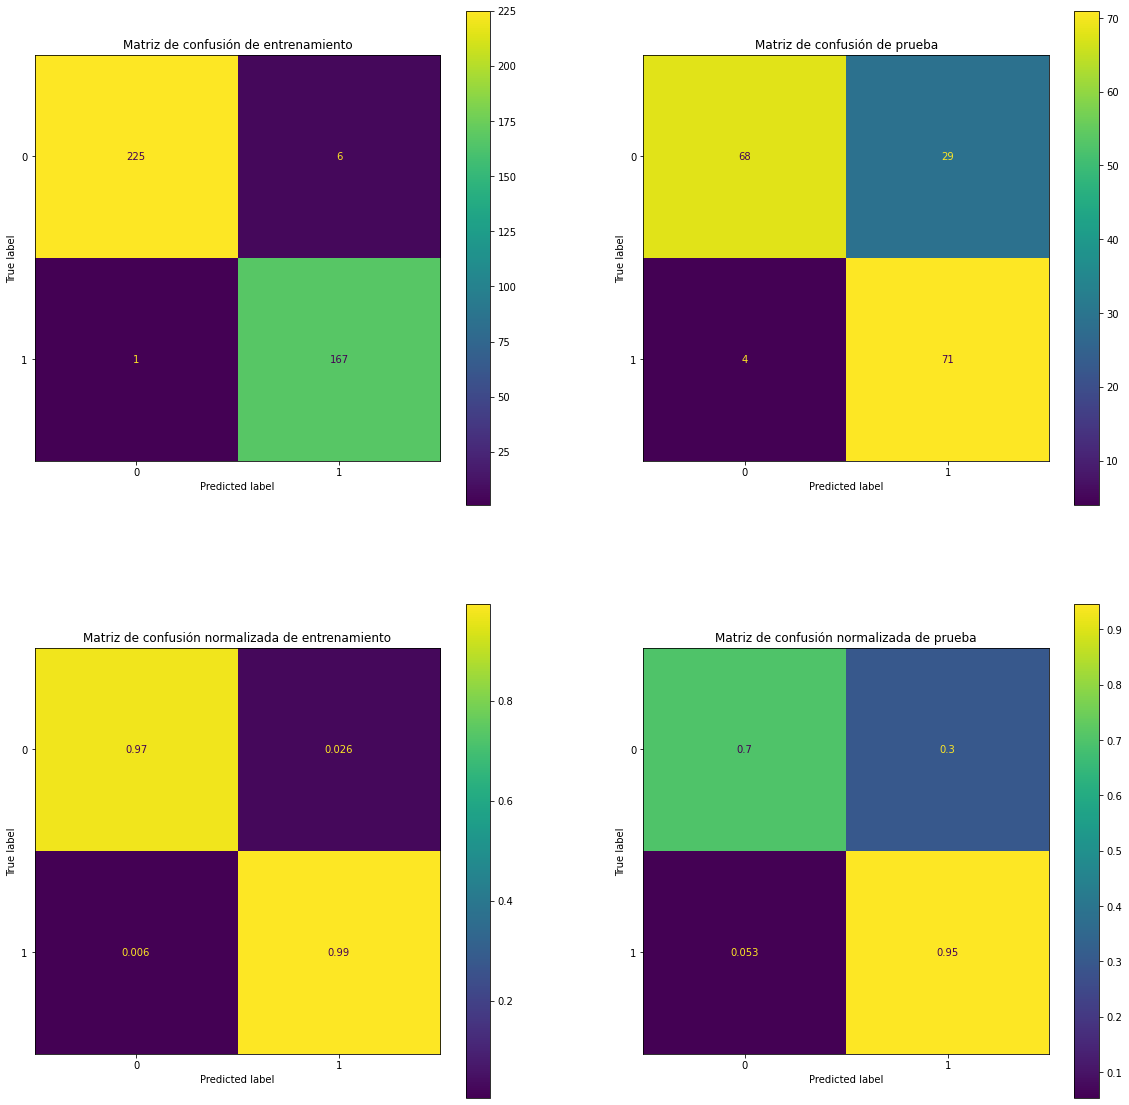

In [ ]:
cm_train = confusion_matrix(y_train, pred_train)
cm_test = confusion_matrix(y_test, pred_test)
cm_train_norm = confusion_matrix(y_train, pred_train, normalize='true')
cm_test_norm = confusion_matrix(y_test, pred_test, normalize='true')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax[0, 0].set_title('Matriz de confusión de entrenamiento')
ax[0, 1].set_title('Matriz de confusión de prueba')
ax[1, 0].set_title('Matriz de confusión normalizada de entrenamiento')
ax[1, 1].set_title('Matriz de confusión normalizada de prueba')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm)
disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm)
disp_train.plot(ax=ax[0, 0])
disp_test.plot(ax=ax[0, 1])
disp_train_norm.plot(ax=ax[1, 0])
disp_test_norm.plot(ax=ax[1, 1])
plt.show()

In [ ]:
rutaPipeline =  "pipeline.joblib"
dump(pipeline, rutaPipeline)

['pipeline.joblib']